In [1]:
import os
# os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources"
os.environ['R_HOME'] = "/usr/lib/R"
import time

import numpy as np
import pandas as pd
import tensorflow as tf
from rpy2 import rinterface
from rpy2.robjects import r
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri
numpy2ri.activate()
from tqdm import tqdm
import seaborn as sns
sns.set_theme(style="white", color_codes=True, font_scale=1.5)
sns.set_palette("Set2")
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
rc('text', usetex=True)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from selective.target import SelectiveTarget
from selective.data import HIV_NRTI
from constrained.nonnegative.entropic import NonnegativeEntropicMap
from constrained.sampling.kernel import imq
from constrained.sampling.svgd import svgd_update
from constrained.sampling.svmd import svmd_update_v2

In [2]:
devtools = importr("devtools")
r("load_all('R-software/selectiveInference')")
glmnet = importr("glmnet")
r("set.seed(1)")
np.random.seed(1)
tf.random.set_seed(1)

R[write to console]: Loading selectiveInference

R[write to console]: Loading required package: glmnet

R[write to console]: Loading required package: Matrix

R[write to console]: Loaded glmnet 4.1

R[write to console]: Loading required package: intervals

R[write to console]: 
Attaching package: ‘intervals’


R[write to console]: The following object is masked from ‘package:Matrix’:

    expand


R[write to console]: Loading required package: survival

R[write to console]: Loading required package: adaptMCMC

R[write to console]: Loading required package: parallel

R[write to console]: Loading required package: coda

R[write to console]: Loading required package: MASS



In [3]:
def run(target, theta_init, method="svmd", K=50, n_chain=100):
    D = theta_init.shape[-1]
    eta0 = target.mirror_map.nabla_psi(theta_init[None, :]) + tf.random.normal([n_chain, K, D], dtype=tf.float64)
    # eta: [n_chain, K, D - 1]
    eta = tf.Variable(eta0)
    theta = target.mirror_map.nabla_psi_star(eta)
    n_iters = 2000
    kernel = imq
    trange = tqdm(range(n_iters))
    optimizer = tf.keras.optimizers.RMSprop(0.01)
#     optimizer = tf.keras.optimizersSGD(lr)
    for t in trange:
        if method == "svmd":
            eta_grad = svmd_update_v2(target, theta, kernel, n_eigen_threshold=0.99)
        elif method == "svgd":
            eta_grad = svgd_update(target, eta, theta, kernel)
        else:
            raise NotImplementedError()
        optimizer.apply_gradients([(-eta_grad, eta)])
        theta = target.mirror_map.nabla_psi_star(eta)
    return tf.reshape(theta, [-1, theta.shape[-1]]).numpy()

In [4]:
# X, _, _ = HIV_NRTI("3TC")
X, y, NRTI_muts = HIV_NRTI("3TC")
n, p = X.shape
s = 10
sigma = 1

# truth = np.zeros(p)
# truth[:s] = np.linspace(0.5, 1, s)
# np.random.shuffle(truth)
# print(np.nonzero(truth))
# print(truth[np.nonzero(truth)[0]])
# truth /= np.sqrt(n)
# truth *= sigma
# y = X.dot(truth) + sigma * np.random.standard_normal(n)

r.assign("n", n)
r.assign("p", p)
r.assign("X", X)
r.assign("y", y)
r.assign("s", s)
_ = r("""
rho = 0.3
lambda_frac = 1.
""")

In [5]:
X.shape, y.shape

((633, 91), (633,))

In [6]:
r("sigma_est = 1")
# theoretical lambda
r("lambda = lambda_frac*selectiveInference:::theoretical.lambda(X, 'ls', sigma_est)")
print("lambda:", r["lambda"])

lambda: [0.10727732]


In [7]:
r("rand_lasso_soln = selectiveInference:::randomizedLasso(X, y, lambda*n, family='gaussian')")
rand_lasso_soln = r["rand_lasso_soln"]
active_vars = rand_lasso_soln.rx2["active_set"] - 1
print("active_vars:", active_vars)
print(active_vars.shape)

active_vars: [ 7 15 16 18 22 23 30 53 66 67 77 81]
(12,)


In [8]:
ci = {}
methods = ["Unadjusted", "Standard", "SVMD", "MSVGD"]

In [9]:
r("fit = rand_lasso_soln$unpen_reg")
coeff = r["fit"].rx2["coefficients"]
ci["Unadjusted"] = r("confint(fit, level=0.95)")
print("coeff:", coeff.shape)
print("unadjusted_ci:", ci["Unadjusted"].shape)

R[write to console]: Waiting for profiling to be done...

coeff: (12,)
unadjusted_ci: (12, 2)


In [10]:
r("targets = selectiveInference:::compute_target(rand_lasso_soln, type='selected', sigma_est=sigma_est)")
r("target_samples = mvrnorm(5000, rep(0,length(rand_lasso_soln$active_set)), targets$targets$cov_target)")

r("linear = rand_lasso_soln$law$sampling_transform$linear_term")
r("offset = rand_lasso_soln$law$sampling_transform$offset_term")
r("theta_init = rand_lasso_soln$law$observed_opt_state")
r("noise_scale = rand_lasso_soln$noise_scale")

array([14.88614936])

In [11]:
r("opt_samples = get_opt_samples(rand_lasso_soln, sampler='norejection', nsample=7000, burnin=2000)")
r("""
PVS = selectiveInference:::randomizedLassoInf(rand_lasso_soln,
                                              targets=targets,
                                              level=0.95,
                                              opt_samples=opt_samples,
                                              target_samples=target_samples)
""")
ci["Standard"] = r["PVS"].rx2["ci"]

[1] "time:"            "2.42708039283752"


In [12]:
A = np.asarray(r["linear"])
print("A:", A.shape)
b = np.squeeze(np.asarray(r["offset"]), -1)
print("b:", b.shape)
theta_init = np.asarray(r["theta_init"])
print("theta_init:", theta_init.shape)
nonneg_map = NonnegativeEntropicMap()
target = SelectiveTarget(nonneg_map, A, b, np.asarray(r["noise_scale"])[0])

A: (12, 12)
b: (12,)
theta_init: (12,)


In [13]:
name_map = {
    "SVMD": "svmd",
    "MSVGD": "svgd",
}
for method in ["SVMD", "MSVGD"]:
    opt_samples = run(target, theta_init, method=name_map[method], K=50, n_chain=100)
    nr, nc = opt_samples.shape
    opt_samples_r = r.matrix(opt_samples, nrow=nr, ncol=nc)
    r.assign("opt_samples", opt_samples_r)
    r("""
    PVS = selectiveInference:::randomizedLassoInf(rand_lasso_soln,
                                                  targets=targets,
                                                  level=0.95,
                                                  opt_samples=opt_samples,
                                                  target_samples=target_samples)
    """)
    ci[method] = r["PVS"].rx2["ci"]

100%|██████████| 2000/2000 [00:05<00:00, 369.02it/s]


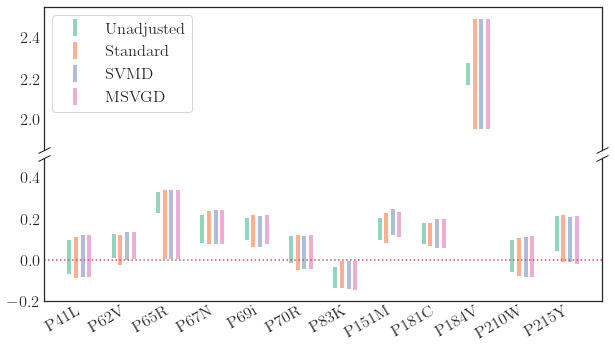

In [14]:
# fig = plt.figure(figsize=(10, 6))
# plt.plot(np.arange(active_vars.shape[0]), truth[active_vars], linestyle='None', marker=".", markersize=10)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6))
ax2.axhline(y=0, color='r', linestyle=':')
fig.subplots_adjust(hspace=0.05)  # adjust space between axes

for ax in (ax1, ax2):
    for i, method in enumerate(methods):
        markers, caps, bars = ax.errorbar(np.arange(active_vars.shape[0]) + (i - 2) * 0.15, coeff, yerr=np.abs(coeff - ci[method].T), ls='none', lw=4, label=method)
        for bar in bars:
            bar.set_alpha(0.7)
    _ = ax.set_xticks(np.arange(active_vars.shape[0]))
    _ = ax.set_xticklabels(NRTI_muts[active_vars])
    ax.tick_params(axis='both', length=0)
# zoom-in / limit the view to different portions of the data
ax1.set_ylim(1.85, 2.55)  # outliers only
ax2.set_ylim(-0.2, 0.5)  # most of the data
ax1.legend()

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

# plt.ylim(ymax=1)
fig.autofmt_xdate()
plt.savefig("hiv_ci.pdf", bbox_inches="tight", dpi=150)

In [15]:
print(ci)

{'Unadjusted': array([[-0.06783847,  0.09818027],
       [ 0.01110582,  0.12406734],
       [ 0.22754143,  0.33333316],
       [ 0.08436492,  0.21906349],
       [ 0.09663615,  0.20693683],
       [-0.01547561,  0.11469363],
       [-0.13771182, -0.03336101],
       [ 0.09783714,  0.20694076],
       [ 0.07704379,  0.18158225],
       [ 2.16793458,  2.27468896],
       [-0.06109006,  0.09495637],
       [ 0.04270516,  0.21416593]]), 'Standard': array([[-0.08798473,  0.10994547],
       [-0.02330141,  0.12097269],
       [ 0.00569311,  0.34176409],
       [ 0.07847316,  0.24075663],
       [ 0.06194024,  0.21742829],
       [-0.05135063,  0.12201173],
       [-0.13619538, -0.00327173],
       [ 0.08403729,  0.22988573],
       [ 0.06593005,  0.17794454],
       [ 1.9527365 ,  2.48988705],
       [-0.07852949,  0.10904351],
       [-0.00897289,  0.2188805 ]]), 'SVMD': array([[-8.21190588e-02,  1.20041165e-01],
       [ 1.77217731e-04,  1.37796615e-01],
       [ 5.69310711e-03,  3.4272218